In [124]:
%pip install ISLP
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.api import add_constant
from sklearn.linear_model import LinearRegression
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

import itertools
from itertools import combinations
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import Stepwise 
from ISLP.models import sklearn_selected
from ISLP.models import sklearn_selection_path

from sklearn.datasets import load_diabetes

In [125]:
# Cargar el dataset de Diabetes
diabetes = load_diabetes()

# Crear un DataFrame con los datos
df_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)

# Agregar la columna de etiquetas (progresión de la diabetes)
df_diabetes['Progression'] = diabetes.target

# Mostrar las primeras filas
df_diabetes.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,Progression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [126]:
np.isnan(df_diabetes['Progression']).sum()

0

### División del DataSet Diabetes

In [127]:
# Preparar los datos
y = np.array(df_diabetes['Progression'])
X = df_diabetes.drop('Progression', axis=1)  # Mantén X como un DataFrame


#Dividir en entrenamiento, validación y prueba
pct_val = 0.20
pct_test = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=pct_test, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=pct_val/(1-pct_test), random_state=100)

# Combinar entrenamiento y validación
X_combined = pd.concat([X_train, X_val], axis=0)
y_combined = np.concatenate([y_train, y_val])

### Elección del modelo óptimo

##### Cp de Mallows

In [128]:
# Modelo reducido: usaremos solo las primeras 4 variables como ejemplo
selected_features = ['age', 'sex', 'bmi', 'bp'] 

def Cp(X_train, y_train, selected_features):

    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = sm.add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat=model_full.scale

    # Modelo reducido:
    X_train_reduced = sm.add_constant(X_train[selected_features])  
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params)

    # Cp de Mallows
    Cp = (rss_reduced + 2 * d_reduced * sigma2_hat) / n

    return Cp

def Cp_alternativa(X_train, y_train, selected_features):
    
    n = len(y_train)

    # Modelo completo para estimar sigma^2
    X_train_full = sm.add_constant(X_train)
    model_full = OLS(y_train, X_train_full).fit()
    sigma2_hat = model_full.scale

    # Modelo reducido:
    X_train_reduced = sm.add_constant(X_train[selected_features])  
    model_reduced = OLS(y_train, X_train_reduced).fit()
    rss_reduced = np.sum(model_reduced.resid ** 2)
    d_reduced = len(model_reduced.params) 

    # Cp de Mallows
    Cp_alternativa = (rss_reduced / sigma2_hat) - (n - 2 * d_reduced)

    return Cp_alternativa

print(f"Cp de Mallows del modelo reducido:             {Cp(X_train, y_train, selected_features):.4f}")
print(f"Cp_alternativa de Mallows del modelo reducido: {Cp_alternativa(X_train, y_train, selected_features):.4f}")

Cp de Mallows del modelo reducido:             3712.2905
Cp_alternativa de Mallows del modelo reducido: 75.6615


sm.add_constant() agrega una columna de unos al inicio de la matriz de predictores. Esa columna representa el término independiente (intercepto) del modelo de regresión. Es necesario porque statsmodels.OLS no incluye automáticamente un intercepto, a diferencia de scikit-learn. Por eso hay que agregarlo manualmente si queremos que el modelo tenga un término constante. 

##### AIC, BIC y $R^{2}$ ajustado

Lo podemos calcular de manera manual utilizando la fórmula que aproximación para modelos lineales de AIC/BIC o utilizar statsmodels, ya que tiene incluido el calculo de AIC/BIC utilizando la verosimilitud del modelo reducido. 

In [129]:
def aic_manual(X_train, y_train, selected_features):
    X_train_red = sm.add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = sm.OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params)                       # número de parámetros
    rss = np.sum(model.resid ** 2)

    # AIC: AIC = (RSS + 2 * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    aic_manual = (rss + 2 * d * sigma2_hat) / n

    return aic_manual

def bic_manual(X_train, y_train, selected_features):
    X_train_red = sm.add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = sm.OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params)                       # número de parámetros
    rss = np.sum(model.resid ** 2)

    # BIC: BIC = (RSS + log(n) * d * sigma^2) / n
    sigma2_hat = rss / (n - d)
    bic_manual = (rss + np.log(n) * d * sigma2_hat) / n

    return bic_manual


def r2_adj_manual(X_train, y_train, selected_features):
    X_train_red = sm.add_constant(X_train[selected_features])

    # Ajustar modelo OLS
    model = sm.OLS(y_train, X_train_red).fit()

    # --- Cálculos manuales ---
    n = len(y_train)                            # número de observaciones
    d = len(model.params) - 1                     # número de parámetros, ya que model.params incluye el intercepto
    y_mean = np.mean(y_train)
    rss = np.sum(model.resid ** 2)
    tss = np.sum((y_train - y_mean)**2)

    # R² ajustado: R2_adj = 1 - (RSS / (n - d - 1)) / (TSS / (n - 1))
    r2_adj_manual = 1 - (rss / (n - d - 1)) / (tss / (n - 1))

    return r2_adj_manual


# --- Comparación con statsmodels ---
X_train_red = sm.add_constant(X_train[selected_features])
model = sm.OLS(y_train, X_train_red).fit()
aic = model.aic
bic = model.bic
r2_adj = model.rsquared_adj

# Mostrar resultados
print("--------- Cálculos Manuales ---------")
print(f"AIC manual:              {aic_manual(X_train, y_train, selected_features):.4f}")
print(f"BIC manual:              {bic_manual(X_train, y_train, selected_features):.4f}")
print(f"R² ajustado (manual):    {r2_adj_manual(X_train, y_train, selected_features):.4f}")

print("\n----------- Statsmodels -------------")
print(f"AIC (statsmodels):       {aic:.4f}")
print(f"BIC (statsmodels):       {bic:.4f}")
print(f"R² ajustado (stats):     {r2_adj:.4f}")


--------- Cálculos Manuales ---------
AIC manual:              3734.8555
BIC manual:              3957.4015
R² ajustado (manual):    0.3734

----------- Statsmodels -------------
AIC (statsmodels):       3407.5083
BIC (statsmodels):       3426.1588
R² ajustado (stats):     0.3734


### Validación y validación cruzada

##### Validación

In [130]:
def validación(X_train, y_train, X_val, y_val, selected_features):
    X_train_red = sm.add_constant(X_train[selected_features])
    model = sm.OLS(y_train, X_train_red).fit()
    X_val_reduced = sm.add_constant(X_val[selected_features]) 
    y_val_pred=model.predict(X_val_reduced)
    MSE=mean_squared_error(y_val,y_val_pred)
    return MSE

print(f"MSE de validación: {validación(X_train, y_train, X_val, y_val, selected_features):.2f}")

MSE de validación: 3525.98


##### Validación Cruzada

In [131]:
def validacion_cruzada(X, y, selected_features, k):
    kf = KFold(n_splits=k, shuffle=True, random_state=100)
    mse_scores = []
    best_mse = float('inf')
    best_model_coefs = None

    for train_index, val_index in kf.split(X):
        X_ktrain, X_kval = X.iloc[train_index], X.iloc[val_index]
        y_ktrain, y_kval = y[train_index], y[val_index]

        # Reducción y constante
        X_ktrain_red = sm.add_constant(X_ktrain[selected_features])
        X_kval_red = sm.add_constant(X_kval[selected_features])

        model_k = sm.OLS(y_ktrain, X_ktrain_red).fit()
        y_pred_k = model_k.predict(X_kval_red)
        mse_k = mean_squared_error(y_kval, y_pred_k)
        mse_scores.append(mse_k)

        # Actualizar si es el mejor modelo
        if mse_k < best_mse:
            best_mse = mse_k
            best_model_coefs = model_k.params

    return best_model_coefs, best_mse, mse_scores

k=5
vc=validacion_cruzada(X_combined, y_combined, selected_features, k=5)

print("\n===== Validación cruzada ({}-fold) =====".format(k))
print("MSE por fold:", np.round(vc[2], 2))
print(f"MSE medio (CV): {np.mean(vc[2]):.4f}")

print("\n===== Mejor modelo =====")
print(f"Mejor MSE: {vc[1]:.4f}")
print("Coeficientes del mejor modelo:")
print(vc[0])


===== Validación cruzada (5-fold) =====
MSE por fold: [3091.74 4271.03 3567.28 4061.16 3581.74]
MSE medio (CV): 3714.5879

===== Mejor modelo =====
Mejor MSE: 3091.7358
Coeficientes del mejor modelo:
const    150.816684
age       53.044923
sex      -99.094644
bmi      771.544968
bp       406.775843
dtype: float64


# Selección de subconjuntos
Aquí vamos a implementar los métodos que reducen el número de parámetros en un modelo restringuiendo el modelo a un subconjunto de los predictores. 
### Selección del mejor subconjunto

In [132]:
def mejor_subconjunto(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):
    # p es el número de características (predictores) en el conjunto de datos
    p = X.shape[1]
    n = len(y)  # n es el número de observaciones
    predictores = X.columns  # Obtiene los nombres de las características (columnas de X)
    resultados_por_k = []  # Lista para almacenar los resultados de cada k

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # Modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })

    # Iterar sobre diferentes valores de k (número de predictores)
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_comb = None  # Inicializa la mejor combinación de predictores

        # Genera todas las combinaciones posibles de k predictores
        for subset in combinations(predictores, k):
            X_k = add_constant(X[list(subset)])  # Agrega la constante a la combinación de predictores
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS con estos predictores
            r2 = modelo.rsquared  # Obtiene el R² del modelo

            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_comb = subset

        # Almacena los resultados de este k en la lista
        resultados_por_k.append({
            'k': k,  # Número de predictores
            'modelo': mejor_modelo_k,  # Mejor modelo encontrado
            'predictores': mejor_comb,  # Mejor combinación de predictores
        })

    metricas = []  # Lista para almacenar las métricas de cada modelo
    mejores_modelos_cv = []  # Lista para almacenar los mejores modelos según validación cruzada

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según el criterio Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            X_val_red = add_constant(X_val[list(res['predictores'])])  # Datos de validación con los predictores seleccionados
            y_val_pred = modelo.predict(X_val_red)  # Predicciones en los datos de validación
            mse_val = mean_squared_error(y_val, y_val_pred)  # Error cuadrático medio (MSE) en validación
            metricas.append(mse_val)

        # Selección según validación cruzada
        elif criterio == 'cv':
            kf = KFold(n_splits=k_cv, shuffle=True, random_state=100)  # Dividir en k pliegues
            best_mse_k = float('inf')  # Inicializa el mejor MSE como infinito
            best_model_k = None  # Inicializa el mejor modelo

            # Realiza la validación cruzada
            for train_idx, val_idx in kf.split(X):
                X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]  # Divide en entrenamiento y validación
                y_train_k, y_val_k = y[train_idx], y[val_idx]  # Divide las etiquetas
                X_train_red = add_constant(X_train_k[list(res['predictores'])])  # Datos de entrenamiento con predictores seleccionados
                modelo_k = OLS(y_train_k, X_train_red).fit()  # Ajusta el modelo en el conjunto de entrenamiento
                X_val_red = add_constant(X_val_k[list(res['predictores'])])  # Datos de validación
                y_pred_k = modelo_k.predict(X_val_red)  # Predicciones en validación
                mse_k = mean_squared_error(y_val_k, y_pred_k)  # Calcula el MSE

                # Si el MSE es mejor, actualiza el mejor modelo
                if mse_k < best_mse_k:
                    best_mse_k = mse_k
                    best_model_k = modelo_k

            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica


In [133]:
# Usar Cp:
modelo_cp, valor_cp = mejor_subconjunto(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ('sex', 'bmi', 'bp', 's1', 's4', 's5')
  Métrica (Cp): 3017.2779
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.70e-43
Time:                        10:52:56   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [134]:
# Usar AIC:
modelo_aic, valor_aic = mejor_subconjunto(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 6
  Predictores: ('sex', 'bmi', 'bp', 's1', 's4', 's5')
  Métrica (AIC): 3343.7095
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.70e-43
Time:                        10:52:59   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [135]:
# Usar BIC:
modelo_bic, valor_bic = mejor_subconjunto(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 5
  Predictores: ('sex', 'bmi', 'bp', 's3', 's5')
  Métrica (BIC): 3366.2221
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.60e-43
Time:                        10:53:02   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [136]:
# Usar R2_adj:
modelo_R2_adj, valor_R2_adj = mejor_subconjunto(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 7
  Predictores: ('sex', 'bmi', 'bp', 's1', 's2', 's4', 's5')
  Métrica (R2_adj): -0.4945
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.81e-42
Time:                        10:53:06   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [137]:
# Usar validación (debe tener los datos de validación):
modelo_val, mse_val = mejor_subconjunto(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 7
  Predictores: ('sex', 'bmi', 'bp', 's1', 's2', 's4', 's5')
  Métrica (validacion): 3062.6161
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.81e-42
Time:                        10:53:09   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

In [138]:
# Usar validación cruzada con k=5:
modelo_cv, mse_cv = mejor_subconjunto(X_combined, y_combined, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 5
  Predictores: ('sex', 'bmi', 'bp', 's3', 's5')
  Mejor MSE en CV: 2592.9503
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     59.19
Date:                Wed, 14 May 2025   Prob (F-statistic):           3.56e-43
Time:                        10:53:12   Log-Likelihood:                -1721.2
No. Observations:                 317   AIC:                             3454.
Df Residuals:                     311   BIC:                             3477.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

### Selección Paso a Paso hacia Adelante

In [139]:
def seleccion_paso_a_paso_adelante(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_restantes = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale  # Estima sigma^2, el error cuadrático medio

    # Modelo nulo (sin predictores)
    modelo_nulo = OLS(y, np.ones((n, 1))).fit()  # Modelo que predice la media de y
    resultados_por_k.append({
        'k': 0,  # El modelo nulo tiene 0 predictores
        'modelo': modelo_nulo,
        'predictores': []
    })

    # Iterar sobre el número de predictores, desde 1 hasta p
    for k in range(1, p + 1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_agregar = []  # Lista de predictores a agregar en cada paso
        
        # Evaluar todos los modelos que agregan un predictor adicional
        for predictor in predictores_restantes:
            predictores_a_probar = list(resultados_por_k[k-1]['predictores']) + [predictor]
            X_k = add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictor_a_agregar = predictor

        # Después de elegir el mejor predictor, eliminarlo de los predictores restantes
        predictores_restantes.remove(predictor_a_agregar)

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            X_val_red = add_constant(X_val[list(res['predictores'])])  # Datos de validación con los predictores seleccionados
            y_val_pred = modelo.predict(X_val_red)  # Predicciones en los datos de validación
            mse_val = mean_squared_error(y_val, y_val_pred)  # Error cuadrático medio (MSE) en validación
            metricas.append(mse_val)

        # Selección según validación cruzada
        elif criterio == 'cv':
            kf = KFold(n_splits=k_cv, shuffle=True, random_state=100)  # Dividir en k pliegues
            best_mse_k = float('inf')  # Inicializa el mejor MSE como infinito
            best_model_k = None  # Inicializa el mejor modelo

            # Realiza la validación cruzada
            for train_idx, val_idx in kf.split(X):
                X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]  # Divide en entrenamiento y validación
                y_train_k, y_val_k = y[train_idx], y[val_idx]  # Divide las etiquetas
                X_train_red = add_constant(X_train_k[list(res['predictores'])])  # Datos de entrenamiento con predictores seleccionados
                modelo_k = OLS(y_train_k, X_train_red).fit()  # Ajusta el modelo en el conjunto de entrenamiento
                X_val_red = add_constant(X_val_k[list(res['predictores'])])  # Datos de validación
                y_pred_k = modelo_k.predict(X_val_red)  # Predicciones en validación
                mse_k = mean_squared_error(y_val_k, y_pred_k)  # Calcula el MSE

                # Si el MSE es mejor, actualiza el mejor modelo
                if mse_k < best_mse_k:
                    best_mse_k = mse_k
                    best_model_k = modelo_k

            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica


In [140]:
# Usar Cp:
modelo_forward_cp, valor_forward_cp = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (Cp): 3018.0770
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.60e-43
Time:                        10:53:12   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------

In [141]:
# Usar AIC:
modelo_forward_aic, valor_forward_aic = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (AIC): 3343.8415
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.60e-43
Time:                        10:53:12   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [142]:
# Usar BIC:
modelo_forward_bic, valor_forward_bic = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 5
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex']
  Métrica (BIC): 3366.2221
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     60.48
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.60e-43
Time:                        10:53:12   Log-Likelihood:                -1665.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     302   BIC:                             3366.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----

In [143]:
# Usar R2_adj:
modelo_forward_r2_adj, valor_forward_r2_adj = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 8
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex', 's1', 's4', 's2']
  Métrica (R2_adj): -0.4933
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     38.35
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.09e-41
Time:                        10:53:13   Log-Likelihood:                -1664.0
No. Observations:                 308   AIC:                             3346.
Df Residuals:                     299   BIC:                             3380.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [144]:
# Usar validación (debe tener los datos de validación):
modelo_forward_val, mse_forward_val = seleccion_paso_a_paso_adelante(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 6
  Predictores: ['bmi', 's5', 'bp', 's3', 'sex', 's1']
  Métrica (validacion): 3036.5921
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.502
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     50.55
Date:                Wed, 14 May 2025   Prob (F-statistic):           8.21e-43
Time:                        10:53:13   Log-Likelihood:                -1665.4
No. Observations:                 308   AIC:                             3345.
Df Residuals:                     301   BIC:                             3371.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.

In [145]:
# Usar validación cruzada con k=5:
modelo_forward_cv, mse_forward_cv = seleccion_paso_a_paso_adelante(X_combined, y_combined, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 8
  Predictores: ['bmi', 's5', 'bp', 's1', 'sex', 's2', 's4', 's6']
  Mejor MSE en CV: 2639.5306
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     38.03
Date:                Wed, 14 May 2025   Prob (F-statistic):           8.96e-42
Time:                        10:53:13   Log-Likelihood:                -1718.3
No. Observations:                 317   AIC:                             3455.
Df Residuals:                     308   BIC:                             3488.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.97

### Selección Paso a Paso hacia Atrás

In [146]:
def seleccion_paso_a_paso_atras(X, y, criterio='AIC', X_val=None, y_val=None, k_cv=5, verbose=True):

    p = X.shape[1]  # Número de predictores
    n = len(y)  # Número de observaciones
    predictores = X.columns  # Nombres de las columnas de X
    predictores_seleccionados = set(predictores)  # Inicializa un conjunto con todos los predictores
    resultados_por_k = []  # Almacena los modelos seleccionados en cada paso

    # Para Cp: modelo completo
    X_full = add_constant(X)  # Agrega la constante (intercepto)
    modelo_full = OLS(y, X_full).fit()  # Ajusta el modelo completo usando OLS
    sigma2_hat = modelo_full.scale

    # Modelo completo (con todos los predictores)
    X_completo = sm.add_constant(X)  # Agregar la constante
    modelo_completo = sm.OLS(y, X_completo).fit()
    resultados_por_k.append({
        'k': p,  # El modelo completo tiene p predictores
        'modelo': modelo_completo,
        'predictores': predictores.tolist()
    })

    # Iterar desde el número de predictores p hasta 1
    for k in range(p, 0, -1):
        mejor_r2 = -np.inf  # Inicializa el mejor R² en un valor muy negativo
        mejor_modelo_k = None  # Inicializa el mejor modelo
        mejor_predictores = None  # Inicializa la mejor combinación de predictores
        predictores_a_eliminar = None  # Predictor a eliminar en cada paso
        
        # Evaluar todos los modelos que eliminan un predictor
        for predictor in predictores_seleccionados:
            predictores_a_probar = list(resultados_por_k[p - k]['predictores'])
            predictores_a_probar.remove(predictor)
            X_k = sm.add_constant(X[predictores_a_probar])  # Agregar la constante
            modelo = sm.OLS(y, X_k).fit()  # Ajusta el modelo OLS
            r2 = modelo.rsquared  # Obtiene el R² del modelo
            
            # Si el R² es mejor que el anterior, actualiza los resultados
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_modelo_k = modelo
                mejor_predictores = predictores_a_probar
                predictores_a_eliminar = predictor  # Corregir aquí: asignamos a la variable correcta

        # Después de elegir el mejor predictor, eliminarlo de los predictores seleccionados
        predictores_seleccionados.remove(predictores_a_eliminar)  # Usar la variable correcta

        # Almacena los resultados del paso k
        resultados_por_k.append({
            'k': k - 1,
            'modelo': mejor_modelo_k,
            'predictores': mejor_predictores,
        })

    # Inicializa las métricas para comparar modelos
    metricas = []
    mejores_modelos_cv = []

    # Calcula las métricas de cada modelo dependiendo del criterio elegido
    for res in resultados_por_k:
        modelo = res['modelo']

        # Selección según Cp
        if criterio == 'Cp':
            k = res['k']
            rss = np.sum(modelo.resid ** 2)  # Residual sum of squares (RSS)
            cp = (rss + 2 * k * sigma2_hat) / n  # Calcula Cp
            metricas.append(cp)

        # Selección según AIC
        elif criterio == 'AIC':
            metricas.append(modelo.aic)  # AIC del modelo ajustado

        # Selección según BIC
        elif criterio == 'BIC':
            metricas.append(modelo.bic)  # BIC del modelo ajustado

        # Selección según R² ajustado
        elif criterio == 'R2_adj':
            metricas.append(-modelo.rsquared_adj)  # R² ajustado (negado para minimización)

        # Selección según validación
        elif criterio == 'validacion':
            if X_val is None or y_val is None:
                raise ValueError("Debes proporcionar X_val e y_val para validación.")  # Validación debe tener datos
            X_val_red = sm.add_constant(X_val[list(res['predictores'])])  # Datos de validación con los predictores seleccionados
            y_val_pred = modelo.predict(X_val_red)  # Predicciones en los datos de validación
            mse_val = mean_squared_error(y_val, y_val_pred)  # Error cuadrático medio (MSE) en validación
            metricas.append(mse_val)

        # Selección según validación cruzada
        elif criterio == 'cv':
            kf = KFold(n_splits=k_cv, shuffle=True, random_state=100)  # Dividir en k pliegues
            best_mse_k = float('inf')  # Inicializa el mejor MSE como infinito
            best_model_k = None  # Inicializa el mejor modelo

            # Realiza la validación cruzada
            for train_idx, val_idx in kf.split(X):
                X_train_k, X_val_k = X.iloc[train_idx], X.iloc[val_idx]  # Divide en entrenamiento y validación
                y_train_k, y_val_k = y[train_idx], y[val_idx]  # Divide las etiquetas
                X_train_red = sm.add_constant(X_train_k[list(res['predictores'])])  # Datos de entrenamiento con predictores seleccionados
                modelo_k = sm.OLS(y_train_k, X_train_red).fit()  # Ajusta el modelo en el conjunto de entrenamiento
                X_val_red = sm.add_constant(X_val_k[list(res['predictores'])])  # Datos de validación
                y_pred_k = modelo_k.predict(X_val_red)  # Predicciones en validación
                mse_k = mean_squared_error(y_val_k, y_pred_k)  # Calcula el MSE

                # Si el MSE es mejor, actualiza el mejor modelo
                if mse_k < best_mse_k:
                    best_mse_k = mse_k
                    best_model_k = modelo_k

            # Almacena el mejor modelo encontrado en la validación cruzada
            metricas.append(best_mse_k)
            mejores_modelos_cv.append({
                'modelo': best_model_k,  # Mejor modelo encontrado
                'mse': best_mse_k,  # Mejor MSE
                'predictores': res['predictores']  # Combinación de predictores
            })

        else:
            raise ValueError("Criterio no reconocido.")  # Si el criterio no es reconocido

    # Selecciona el modelo con la mejor métrica
    idx_mejor = int(np.argmin(metricas))  # Encuentra el índice del mejor modelo (mínimo de las métricas)
    mejor_modelo = resultados_por_k[idx_mejor]  # Obtiene el mejor modelo

    # Si el criterio es validación cruzada, devuelve el mejor modelo y su MSE
    if criterio == 'cv':
        mejor_modelo_cv = mejores_modelos_cv[idx_mejor]
        if verbose:
            print(f"\n=== Mejor modelo según CV ===")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Mejor MSE en CV: {mejor_modelo_cv['mse']:.4f}")  # MSE del mejor modelo
            print(mejor_modelo_cv['modelo'].summary())  # Resumen del modelo
        return mejor_modelo_cv, mejor_modelo_cv['mse']  # Devuelve el mejor modelo y su MSE

    # Si el criterio no es validación cruzada, devuelve el mejor modelo según el criterio seleccionado
    else:
        if verbose:
            print(f"\n========= Mejor modelo según {criterio} =========")
            print(f"  k = {mejor_modelo['k']}")  # Número de predictores
            print(f"  Predictores: {mejor_modelo['predictores']}")  # Combinación de predictores
            print(f"  Métrica ({criterio}): {metricas[idx_mejor]:.4f}")  # Métrica del mejor modelo
            print(mejor_modelo['modelo'].summary())  # Resumen del modelo
        return mejor_modelo, metricas[idx_mejor]  # Devuelve el mejor modelo y su métrica

In [147]:
# Usar Cp:
modelo_backward_cp, valor_backward_cp = seleccion_paso_a_paso_atras(X_train, y_train, criterio='Cp', verbose=True)


========= Mejor modelo según Cp =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (Cp): 3017.2779
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.70e-43
Time:                        10:53:14   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [148]:
# Usar AIC:
modelo_backward_aic, valor_backward_aic = seleccion_paso_a_paso_atras(X_train, y_train, criterio='AIC', verbose=True)


========= Mejor modelo según AIC =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (AIC): 3343.7095
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.70e-43
Time:                        10:53:14   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [149]:
# Usar BIC:
modelo_backward_bic, valor_backward_bic = seleccion_paso_a_paso_atras(X_train, y_train, criterio='BIC', verbose=True)


========= Mejor modelo según BIC =========
  k = 6
  Predictores: ['sex', 'bmi', 'bp', 's1', 's4', 's5']
  Métrica (BIC): 3369.8202
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     50.93
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.70e-43
Time:                        10:53:14   Log-Likelihood:                -1664.9
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     301   BIC:                             3370.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975

In [150]:
# Usar R2_adj:
modelo_backward_r2_adj, valor_backward_r2_adj = seleccion_paso_a_paso_atras(X_train, y_train, criterio='R2_adj', verbose=True)


========= Mejor modelo según R2_adj =========
  k = 7
  Predictores: ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5']
  Métrica (R2_adj): -0.4945
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.81e-42
Time:                        10:53:14   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025 

In [151]:
# Usar validación (debe tener los datos de validación):
modelo_backward_val, mse_backward_val = seleccion_paso_a_paso_atras(X_train, y_train, criterio='validacion', X_val=X_val, y_val=y_val, verbose=True)


========= Mejor modelo según validacion =========
  k = 7
  Predictores: ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5']
  Métrica (validacion): 3062.6161
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     43.90
Date:                Wed, 14 May 2025   Prob (F-statistic):           1.81e-42
Time:                        10:53:15   Log-Likelihood:                -1664.2
No. Observations:                 308   AIC:                             3344.
Df Residuals:                     300   BIC:                             3374.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|   

In [152]:
# Usar validación cruzada con k=5:
modelo_backward_cv, mse_backward_cv = seleccion_paso_a_paso_atras(X_combined, y_combined, criterio='cv', k_cv=5, verbose=True)


=== Mejor modelo según CV ===
  k = 8
  Predictores: ['sex', 'bmi', 'bp', 's1', 's2', 's4', 's5', 's6']
  Mejor MSE en CV: 2639.5306
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     38.03
Date:                Wed, 14 May 2025   Prob (F-statistic):           8.96e-42
Time:                        10:53:15   Log-Likelihood:                -1718.3
No. Observations:                 317   AIC:                             3455.
Df Residuals:                     308   BIC:                             3488.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.97

# Métodos de Penalización

Es muy importante estandarizar los datos, ya que tanto el Ridge Regression como el LASSO son muy sensibles a la escala. 

NOTA: El parámetro $\lambda$ se llama alpha en Sklearn. 

In [153]:
# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_combined_scaled = scaler.fit_transform(X_combined)

### Ridge Regression

Si simplemente queremos saber cuáles son los coeficientes que calcula la Ridge Regression para un valor específico de $\lambda$ (alpha), podemos utilizar la función Ridge del módulo sklearn.linear_model. Esta permite ajustar el modelo con un valor fijo de regularización y obtener directamente los coeficientes.

En cambio, si queremos encontrar para qué valor de $\lambda$ (alpha) se obtiene el mejor modelo, podemos utilizar RidgeCV, que realiza una validación cruzada para seleccionar automáticamente el valor óptimo de alpha. Este proceso evalúa el rendimiento del modelo en diferentes particiones de los datos y elige el alpha que minimiza el error, ofreciendo así una solución más robusta y generalizable.

In [154]:
ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train)

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del Ridge Regresion")
print(coef_df) 


Coeficientes del Ridge Regresion
  Feature  Coefficient  Abs_Coefficient
2     bmi    23.971630        23.971630
8      s5    23.365554        23.365554
3      bp    13.894589        13.894589
1     sex    -9.363077         9.363077
7      s4     8.150650         8.150650
4      s1    -7.477267         7.477267
6      s3    -6.041792         6.041792
9      s6     4.467173         4.467173
0     age    -1.955954         1.955954
5      s2     0.370411         0.370411


El valor óptimo de alpha es: 10.0

Coeficientes del mejor modelo (Ridge Regression):
  Feature  Coefficient  Abs_Coefficient
2     bmi    23.971630        23.971630
8      s5    23.365554        23.365554
3      bp    13.894589        13.894589
1     sex    -9.363077         9.363077
7      s4     8.150650         8.150650
4      s1    -7.477267         7.477267
6      s3    -6.041792         6.041792
9      s6     4.467173         4.467173
0     age    -1.955954         1.955954
5      s2     0.370411         0.370411

MSE en entrenamiento: 2887.4897
R² en entrenamiento: 0.5061


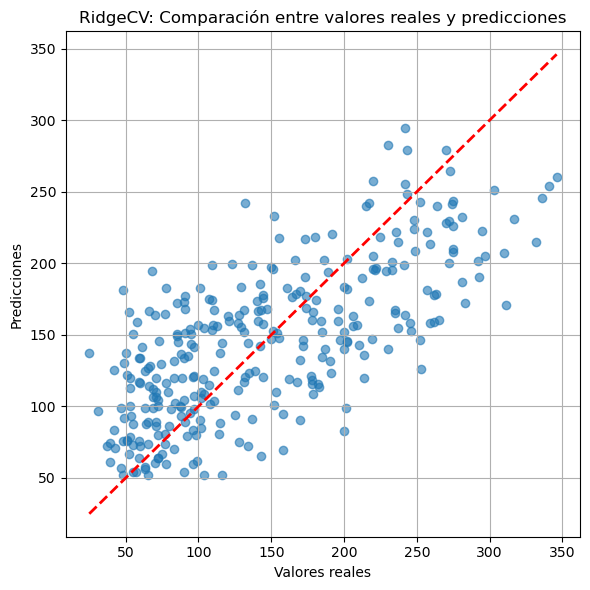

In [155]:
# Definir valores de alpha (desde 10^-6 a 10^6)
alphas = np.logspace(-6, 6, 13)

# Ajustar modelo RidgeCV con validación cruzada
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv.fit(X_train_scaled, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {ridge_cv.alpha_}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (Ridge Regression):")
print(coef_df) 

# Hacer predicciones en los datos de entrenamiento
y_pred = ridge_cv.predict(X_train_scaled)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('RidgeCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [156]:
cv_mse = np.mean(ridge_cv.cv_values_, axis=0)

results_df = pd.DataFrame({
    'Alpha (lambda)': ridge_cv.alphas,
    'Mean Val Score (MSE)': cv_mse
})
results_df['Rank Val Score'] = results_df['Mean Val Score (MSE)'].rank(method='min')
results_df = results_df.sort_values(by='Rank Val Score')

print(results_df)

    Alpha (lambda)  Mean Val Score (MSE)  Rank Val Score
7        10.000000           3078.964590             1.0
6         1.000000           3086.389501             2.0
5         0.100000           3089.995401             3.0
4         0.010000           3090.596789             4.0
3         0.001000           3090.660730             5.0
2         0.000100           3090.667164             6.0
1         0.000010           3090.667808             7.0
0         0.000001           3090.667872             8.0
8       100.000000           3111.132958             9.0
9      1000.000000           3959.777927            10.0
10    10000.000000           5432.724482            11.0
11   100000.000000           5832.660080            12.0
12  1000000.000000           5879.373116            13.0


Otra forma seria aplicando GridSearchCV al Ridge

In [157]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con Ridge
grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto de entrenamiento y validación
grid_search.fit(X_combined_scaled, y_combined)

# Ver el mejor modelo
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame para mostrar los resultados de manera ordenada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de la prueba (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo
coefficients = best_model.coef_

# Crear un DataFrame para mostrar los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Si X_train es un DataFrame con nombres de columna
    'Coefficient': coefficients
})

# Ordenar los coeficientes por valor absoluto para ver cuáles tienen mayor impacto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"Coeficientes del mejor modelo: {best_model}")
print(coef_df)


Coeficientes del mejor modelo: Ridge(alpha=10.0)
  Feature  Coefficient  Abs_Coefficient
8      s5    25.420140        25.420140
2     bmi    24.791612        24.791612
3      bp    15.178980        15.178980
1     sex   -10.223172        10.223172
4      s1    -8.246789         8.246789
6      s3    -5.899875         5.899875
7      s4     5.198683         5.198683
9      s6     3.123203         3.123203
0     age    -2.005556         2.005556
5      s2     0.877069         0.877069


In [158]:
print("Resultados de la búsqueda con validación cruzada (Ridge Regression):")
results_df

Resultados de la búsqueda con validación cruzada (Ridge Regression):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
7,10.0,3044.838040,165.697585,2903.896144,35.860473,1
6,1.0,3046.526908,144.392991,2892.039315,34.231027,2
5,0.1,3048.948179,140.138783,2890.703524,34.112758,3
4,0.01,3049.389778,139.714948,2890.680407,34.110799,4
3,0.001,3049.437147,139.673160,2890.680161,34.110778,5
2,0.0001,3049.441918,139.668988,2890.680158,34.110778,6
1,0.00001,3049.442396,139.668571,2890.680158,34.110778,7
0,0.000001,3049.442443,139.668529,2890.680158,34.110778,8
8,100.0,3116.990066,257.610947,2990.977421,39.713282,9
9,1000.0,4073.401362,486.532953,3952.249441,85.080275,10


Hay alternativas al GridSearchCV cuando el espacio de parámetros es muy extenso o es computacionalmente costoso el fitear todos los posibles modelos, se puede realizar una búsqueda al azar (RandomizedSearchCV). Un punto intermedio entre Grid Search y Random Search es HalvingRandomSearchCV, que evalúa todas las combinaciones usando una muestra pequeña de los datos, e iterativamente aumenta la muestra en aquellos modelos que presentan mejores resultados

### LASSO

Todo lo visto anteriormente con el Ridge Regression se puede aplicar también al LASSO

In [159]:
# Ajustar el modelo ElasticNet con valores específicos de alpha y l1_ratio
elastic_net = ElasticNet(alpha=1, l1_ratio=0.5, max_iter=10000)
elastic_net.fit(X_train_scaled, y_train)

# Crear DataFrame con coeficientes y ordenarlos por valor absoluto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_net.coef_
})

# Añadir columna para los coeficientes en valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()

# Ordenar por valor absoluto de los coeficientes
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print("\nCoeficientes del ElasticNet")
print(coef_df)


Coeficientes del ElasticNet
  Feature  Coefficient  Abs_Coefficient
2     bmi    17.560199        17.560199
8      s5    14.903345        14.903345
3      bp    10.255018        10.255018
6      s3    -7.913419         7.913419
7      s4     6.694851         6.694851
9      s6     5.809055         5.809055
1     sex    -4.790914         4.790914
5      s2    -1.084140         1.084140
0     age    -0.000000         0.000000
4      s1     0.000000         0.000000


El valor óptimo de alpha es: 0.000001

Coeficientes del mejor modelo (Lasso):
  Feature  Coefficient  Abs_Coefficient
8      s5    34.090133        34.090133
4      s1   -33.052373        33.052373
2     bmi    24.236840        24.236840
5      s2    19.784920        19.784920
3      bp    14.441312        14.441312
7      s4    11.644552        11.644552
1     sex   -10.135548        10.135548
6      s3     6.045280         6.045280
9      s6     3.754299         3.754299
0     age    -2.202154         2.202154

MSE en entrenamiento: 2873.7577
R² en entrenamiento: 0.5085


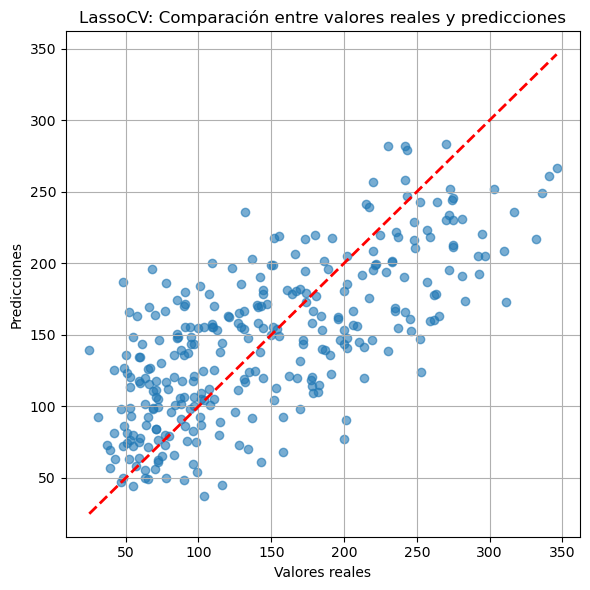

In [160]:
# Definir valores de alpha (desde 10^-6 a 10^6)
alphas = np.logspace(-6, 6, 13)

# Ajustar modelo LassoCV con validación cruzada
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

# Mostrar el mejor alpha encontrado
print(f"El valor óptimo de alpha es: {lasso_cv.alpha_:.6f}")

# Crear DataFrame con coeficientes y ordenarlos por impacto
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lasso_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar top 10 características más relevantes
print("\nCoeficientes del mejor modelo (Lasso):")
print(coef_df.head(10))

# Hacer predicciones en los datos de entrenamiento
y_pred = lasso_cv.predict(X_train_scaled)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs. valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('LassoCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()


In [161]:
# Definir el grid de valores para alpha (lambda)
param_grid = {
    'alpha': np.logspace(-6, 6, 13)
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con Lasso
grid_search = GridSearchCV(
    estimator=Lasso(max_iter=10000),  # Aumentamos max_iter para evitar warnings de convergencia
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto combinado (ya escalado)
grid_search.fit(X_combined_scaled, y_combined)

# Obtener el mejor modelo encontrado
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame con los resultados de la validación cruzada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de validación (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Obtener los coeficientes del mejor modelo Lasso
coefficients = best_model.coef_

# Crear un DataFrame con los nombres de las características y sus coeficientes
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Ordenar los coeficientes por su valor absoluto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"\nCoeficientes del mejor modelo Lasso (alpha = {best_model.alpha}):")
print(coef_df)


Coeficientes del mejor modelo Lasso (alpha = 1.0):
  Feature  Coefficient  Abs_Coefficient
2     bmi    25.089905        25.089905
8      s5    24.967142        24.967142
3      bp    14.074296        14.074296
6      s3    -9.229839         9.229839
1     sex    -8.673186         8.673186
4      s1    -3.355739         3.355739
9      s6     1.895999         1.895999
0     age    -0.809595         0.809595
5      s2    -0.000000         0.000000
7      s4     0.000000         0.000000


In [162]:
print("Resultados de la búsqueda con validación cruzada (Lasso):")
results_df

Resultados de la búsqueda con validación cruzada (Lasso):


,Alpha (lambda),Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
6,1.0,3045.840611,169.553138,2915.309154,36.852231,1
5,0.1,3047.932305,144.402947,2893.672266,34.250627,2
4,0.01,3049.063005,139.837735,2890.721307,34.108566,3
3,0.001,3049.400252,139.684049,2890.680570,34.110756,4
2,0.0001,3049.438186,139.670063,2890.680162,34.110778,5
1,0.00001,3049.442022,139.668678,2890.680158,34.110778,6
0,0.000001,3049.442406,139.668540,2890.680158,34.110778,7
7,10.0,3322.662129,256.625935,3228.775208,50.377298,8
8,100.0,6035.738169,622.613972,5920.495475,149.086014,9
9,1000.0,6035.738169,622.613972,5920.495475,149.086014,9


### ElasticNet

ElasticNet es un modelo de regresión lineal regularizada que combina las penalizaciones de Lasso (L1) y Ridge (L2).

Es ideal cuando:
- Hay muchas variables predictoras.
- Existe multicolinealidad entre las variables.
- Se quiere un equilibrio entre selección de variables y estabilidad del modelo.

Minimiza:

$\text{RSS} + \alpha \left( \lambda \sum | \beta_j | + (1 - \lambda) \sum \beta_j^2 \right)$

Donde:
- RSS: Suma de errores cuadrados.
- $\alpha$ (alpha): Controla la fuerza de la regularización.
- $\lambda$ (l1_ratio): Controla la proporción entre Lasso (L1) y Ridge (L2).

  - l1_ratio = 1 → Lasso puro.
  - l1_ratio = 0 → Ridge puro.


#####  Ventajas del ElasticNet

- Selecciona automáticamente variables relevantes (como Lasso).
- Reduce la varianza y mejora la estabilidad en presencia de multicolinealidad (como Ridge).
- Útil cuando:
  - Hay más variables que observaciones.
  - Lasso por sí solo elimina demasiadas variables importantes.
  - Las variables están correlacionadas entre sí.


##### Implementación en scikit-learn

- ElasticNet: Ajuste manual de alpha y l1_ratio.
- ElasticNetCV: Selección automática de los mejores hiperparámetros mediante validación cruzada.

Mejor alpha encontrado: 0.1
Mejor l1_ratio encontrado: 0.15

Coeficientes del mejor modelo (ElasticNet):
  Feature  Coefficient  Abs_Coefficient
2     bmi    23.041661        23.041661
8      s5    20.742577        20.742577
3      bp    13.334085        13.334085
1     sex    -8.657304         8.657304
6      s3    -7.902417         7.902417
7      s4     7.583084         7.583084
9      s6     4.921014         4.921014
4      s1    -3.179109         3.179109
5      s2    -2.312859         2.312859
0     age    -1.650647         1.650647

MSE en entrenamiento: 2898.7649
R² en entrenamiento: 0.5042


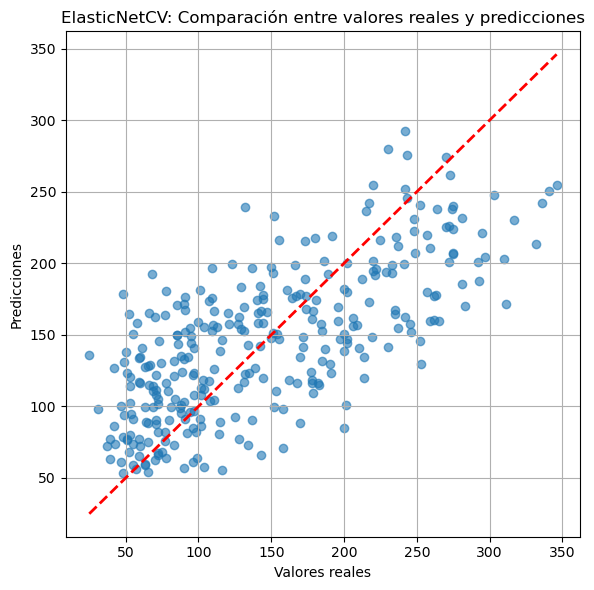

In [163]:
# Definir valores posibles de alpha (fuerza de regularización)
alphas = np.logspace(-3, 3, 7)

# Definir valores posibles de l1_ratio (proporción entre L1 y L2)
# l1_ratio = 1 → Lasso, l1_ratio = 0 → Ridge
l1_ratios = np.append(0.01, np.linspace(0.1, 1.0, 19))

# Ajustar modelo ElasticNetCV con validación cruzada
elastic_cv = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=10000)
elastic_cv.fit(X_train_scaled, y_train)

# Mostrar el mejor alpha y l1_ratio encontrados
print(f"Mejor alpha encontrado: {elastic_cv.alpha_}")
print(f"Mejor l1_ratio encontrado: {elastic_cv.l1_ratio_:.2f}")

# Crear DataFrame con coeficientes y ordenarlos
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': elastic_cv.coef_
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nCoeficientes del mejor modelo (ElasticNet):")
print(coef_df.head(10))  # Top 10 características más relevantes

# Hacer predicciones en los datos de entrenamiento
y_pred = elastic_cv.predict(X_train_scaled)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"\nMSE en entrenamiento: {mse:.4f}")
print(f"R² en entrenamiento: {r2:.4f}")

# Visualización de predicciones vs valores reales
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('ElasticNetCV: Comparación entre valores reales y predicciones')
plt.grid(True)
plt.tight_layout()
plt.show()

In [164]:
# Definir el grid de valores para alpha (lambda) y l1_ratio (mezcla entre LASSO y Ridge)
param_grid = {
    'alpha': np.logspace(-3, 3, 7),
    'l1_ratio': np.append(0.01, np.linspace(0.1, 1.0, 19))  # 0 es Ridge, 1 es LASSO
}

# Crear un scorer basado en MSE (menor es mejor)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Configurar el GridSearchCV con ElasticNet
grid_search = GridSearchCV(
    estimator=ElasticNet(),
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=mse_scorer,
    return_train_score=True
)

# Ajustar el modelo en el conjunto de entrenamiento y validación
grid_search.fit(X_combined_scaled, y_combined)

# Ver el mejor modelo
best_model = grid_search.best_estimator_

# Extraer resultados del grid_search
results = grid_search.cv_results_

# Crear un DataFrame para mostrar los resultados de manera ordenada
results_df = pd.DataFrame({
    'Alpha (lambda)': results['param_alpha'],
    'L1 Ratio': results['param_l1_ratio'],
    'Mean Val Score (MSE)': -results['mean_test_score'],
    'Std Val Score': results['std_test_score'],
    'Mean Train Score (MSE)': -results['mean_train_score'],
    'Std Train Score': results['std_train_score'],
    'Rank Val Score': results['rank_test_score']
})

# Ordenar los resultados por la puntuación de la prueba (MSE)
results_df = results_df.sort_values(by='Rank Val Score')

# Mostrar los resultados
#print("\nResultados de la búsqueda con validación cruzada (ElasticNet):")
#print(results_df)

# Obtener los coeficientes del mejor modelo ElasticNet
coefficients = best_model.coef_

# Crear un DataFrame para mostrar los coeficientes junto con los nombres de las características
coef_df = pd.DataFrame({
    'Feature': X_train.columns,  # Si X_train es un DataFrame con nombres de columna
    'Coefficient': coefficients
})

# Ordenar los coeficientes por valor absoluto para ver cuáles tienen mayor impacto
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Mostrar los coeficientes ordenados
print(f"Coeficientes del mejor modelo: {best_model}")
print(coef_df)


Coeficientes del mejor modelo: ElasticNet(alpha=0.1, l1_ratio=0.85)
  Feature  Coefficient  Abs_Coefficient
8      s5    25.762486        25.762486
2     bmi    24.991770        24.991770
3      bp    15.166646        15.166646
1     sex   -10.175682        10.175682
4      s1    -8.404047         8.404047
6      s3    -5.766487         5.766487
7      s4     5.088687         5.088687
9      s6     2.936202         2.936202
0     age    -1.948553         1.948553
5      s2     0.914920         0.914920


In [165]:
print("Resultados de la búsqueda con validación cruzada (Elastic Net)):")
results_df

Resultados de la búsqueda con validación cruzada (Elastic Net)):


,Alpha (lambda),L1 Ratio,Mean Val Score (MSE),Std Val Score,Mean Train Score (MSE),Std Train Score,Rank Val Score
56,0.1,0.85,3043.356531,159.513781,2900.865999,34.909130,1
55,0.1,0.8,3043.418614,162.246755,2902.465987,35.257683,2
54,0.1,0.75,3043.702721,164.581391,2903.712783,35.655776,3
53,0.1,0.7,3044.137459,166.691998,2904.669443,36.104502,4
57,0.1,0.9,3044.567319,155.631303,2898.995958,34.574611,5
...,...,...,...,...,...,...,...
111,100.0,0.6,6035.738169,622.613972,5920.495475,149.086014,111
110,100.0,0.55,6035.738169,622.613972,5920.495475,149.086014,111
109,100.0,0.5,6035.738169,622.613972,5920.495475,149.086014,111
123,1000.0,0.2,6035.738169,622.613972,5920.495475,149.086014,111
